## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


/Users/vaanigupta/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [2]:
## your code here
debar_db = pd.read_csv("pset2_inputdata/debar.csv")
debar_db.head()

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [3]:
## your code here
rows = debar_db.shape[0]
print(rows)
unique_names = debar_db["Name"].nunique()
print(unique_names)

114
98


### There are multiple rows for some employers since the number of unique employer names is smaller than the number of rows in the data frame. 

## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [4]:
## your code here
count_names = debar_db["Name"].value_counts()
duplicate_names = count_names[count_names > 1].index.to_list()
debar_db["is_repeated"] = debar_db["Name"].isin(duplicate_names)
debar_db

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016,False
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016,False
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015,False
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016,False
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016,False
...,...,...,...,...,...,...,...
109,Dove Creek Farms,"Mount Vernon, TX",Failure to Respond to Audit Request,2 years,2/9/2018,2/8/2020,True
110,Jesus Ledesma,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20,False
111,Turner Farms,"Healy, KS",Failure to comply with the employer's obligati...,7 months,7/17/19,2/10/20,True
112,B & R Harvesting and Paul Cruz (individual),"Collins, Georgia",WHD Debarment,3 years,4/9/17,4/9/20,False


In [5]:
debar_db[debar_db["is_repeated"]]

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True
14,Sharon Mathis,"Tifton, GA",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
15,SRT Farms,"Morton, TX",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
16,Mark Duncan,"Roosevelt, UT",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
17,"Maple Ridge Custom Services, LLC","Altheimer, AK",Failure to respond to audit (partial response),2 years,11/16/2014,11/15/2016,True
18,F&W Farms,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016,True


### For cases where is_repeated is true, there are instances where the same employer in the same city and state has the same violation but the end dates are different or are not formatted in the same way. For instance, for Dove Creek Farms, the end date for one entry is 2/8/2018 and is 2/8/2020 for the other entry; similarly, for Turner Farms, the year of the end date in one entry is written as 2020 and for the other entry, it's written as 20. Or for the same employer, same start and end dates, and same city and state, the violation description differs (same message, but written differently). This is the case for Autumn Hill Orchard. Another source of difference can also stem from how the states are written in the city, state column, as the full state name or abbreviation is used. There is an inconsistent format for many of the columns in this data frame that result in the is_repeated flag being marked as true. 

### Cleaning City, State Column (Removing State Abbreviation Errors) For 1.3 & 1.4

In [6]:
# CLEANING CITY, STATE COLUMN FROM ERRORS
# clean City, State -- ensure that only state abbreviations are inside the column City,State
debar_db.loc[:, "City, State"] = debar_db["City, State"].str.replace("Utah", "UT")
debar_db.loc[:, "City, State"] = debar_db["City, State"].str.replace("Texas", "TX")
debar_db.loc[:, "City, State"] = debar_db["City, State"].str.replace("Altheimer, AK", "Altheimer, AR")

In [7]:
mult_debar = debar_db[debar_db["is_repeated"]]
mult_debar.head()
mult_debar.shape

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True


(32, 7)

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [8]:
## your code here
# employer is name AND city, state pair 
mult_debar_wide = mult_debar.pivot_table(index=["Name", "City, State"], columns=mult_debar.groupby(["Name", "City, State"]).cumcount(), values="Start date", aggfunc="first")
mult_debar_wide.columns = ["start_date_viol1", "start_date_viol2"]
mult_debar_wide.head()
mult_debar_wide.shape

,,start_date_viol1,start_date_viol2
Name,"City, State",,
Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018


(17, 2)

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [9]:
## your code here
mult_debar_wide["is_dup"] = mult_debar_wide["start_date_viol1"] == mult_debar_wide["start_date_viol2"]
# mult_debar_wide

duplicate_indices = mult_debar_wide[mult_debar_wide["is_dup"]].index.to_list()
duplicates_indicator = debar_db[["Name", "City, State"]].apply(tuple, axis=1).isin(duplicate_indices)

duplicate_rows = debar_db[duplicates_indicator]
# duplicate_rows.shape
clean_rows = duplicate_rows.drop_duplicates(subset=["Name", "City, State"])
# clean_rows.shape

non_duplicate_rows = debar_db[~duplicates_indicator]
# non_duplicate_rows

debar_clean = pd.concat((clean_rows, non_duplicate_rows), axis = 0)
debar_clean = debar_clean.drop(columns = ["is_repeated"])
debar_clean

debar_clean.shape
debar_clean["Name"].nunique()

,Name,"City, State",Violation,Duration,Start date,End date
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016
14,Sharon Mathis,"Tifton, GA",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016
...,...,...,...,...,...,...
107,Walker Place,"Danville, IL",Failure to comply with the employer's obligati...,2 months,11/19/2019,1/26/2020
108,County Fair Farm (company) and Andrew Williams...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020
110,Jesus Ledesma,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20
112,B & R Harvesting and Paul Cruz (individual),"Collins, Georgia",WHD Debarment,3 years,4/9/17,4/9/20


(102, 6)

98

# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset4_inputdata`

In [10]:
# your code here to load the data 

jobs = pd.read_csv("pset2_inputdata/jobs.csv")
jobs

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"Fazio Farms Operating Company, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,Charlie Sunderland,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Michael Rudebusch,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Lodahl Farms,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"Dunson Harvesting, Inc.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,H-300-20351-963307,Determination Issued - Certification,2020-12-17 10:34:09.530,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,James L Schneller,NaN,...,N,1,N,NaN,12.68,55.0,12709914373,jims4463@aol.com,NaN,0
2716,H-300-20351-963399,Determination Issued - Certification,2020-12-17 14:37:57.920,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,Stephen G Myers,NaN,...,N,1,N,NaN,12.68,55.0,12708780028,vjpm76@gmail.com,https://kentucky.gov/employment/Pages/default....,1
2717,H-300-20351-964097,Determination Issued - Certification,2020-12-22 12:21:32.370,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,Andy Povey,Andy Povey Farms,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0
2718,H-300-20351-965435,Determination Issued - Certification,2020-12-22 12:18:43.280,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,"Silver Creek Seed, LLC",NaN,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0


##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [11]:
## your code here
name_intersection = debar_clean.merge(jobs, left_on = "Name", right_on="EMPLOYER_NAME", how="inner")
name_intersection

,Name,"City, State",Violation,Duration,Start date,End date,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,Rafael Barajas,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,...,Y,3,Y,12.68,12.68,55.0,18632732686,NaN,https://seasonaljobs.dol.gov/,7


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [12]:
## insert your code to turn into uppercase here
# are these columns or data frames? 
employer_name_capital = [employer_name.upper() for employer_name in jobs["EMPLOYER_NAME"]]
name_capital = [name.upper() for name in debar_clean["Name"]]

In [13]:
## insert your code for the random sample
print("Sample from Jobs Data Frame")
random.sample(employer_name_capital, 15)

print("Sample from Debar Clean Data Frame")
random.sample(name_capital, 15)

Sample from Jobs Data Frame


['20 MILE SHEEP LLC',
 'COOSAW AG, LLC',
 'MARIO A VARGAS',
 'LUCAS SIMON',
 'RAASCH BROTHERS, LLC',
 'TIMBER LAKE ELK RANCH, LLC',
 'DESERT VALLEY HONEY LLC',
 'ROGER BENSON ',
 'WESTERN RANGE ASSOCIATION',
 'BLUE MOUNTAIN CATTLE INC.',
 'WEBSTER ORCHARDS, INC',
 'SODVILLE FARM SERVICES, INC.',
 'FRESH HARVEST, INC.',
 'LUCKY AG, INC.',
 'M&S FRUGE FARMS LLC']

Sample from Debar Clean Data Frame


['CADDO CREEK RANCH, DBA PARADISE RANCH',
 'MARK DUNCAN',
 'ROSALVA GARCIA',
 'AB RANCH',
 'AUTUMN HILL ORCHARD',
 'DONNA LUCIO',
 'CITY PINESTRAW AND HARVESTING',
 'AGECY II, LLC',
 'TRIANGLE J FARMS',
 'AGECY I LLC',
 'TODD DAULTON',
 'HAITI/USA WORKFORCE, LLC',
 'OLSON FARMS',
 'WALKER PLACE',
 'DOVE CREEK FARMS']

In [14]:
## insert your code for assigning the uppercase names back to the data
jobs["EMPLOYER_NAME"] = employer_name_capital
debar_clean["Name"] = name_capital

print("Sample from Jobs Data Frame")
jobs.head()
print("Sample from Debar Clean Data Frame")
debar_clean.head()

Sample from Jobs Data Frame


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"FAZIO FARMS OPERATING COMPANY, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,CHARLIE SUNDERLAND,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,MICHAEL RUDEBUSCH,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,LODAHL FARMS,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"DUNSON HARVESTING, INC.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4


Sample from Debar Clean Data Frame


,Name,"City, State",Violation,Duration,Start date,End date
6,ANNABELLA LAND & CATTLE,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015
7,AUTUMN HILL ORCHARD,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016
8,"CADDO CREEK RANCH, DBA PARADISE RANCH","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016
12,ROLLO FARM LABOR CONTRACTOR,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016
14,SHARON MATHIS,"Tifton, GA",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016


### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [15]:
# what are the github issue for examples of what to return?
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [16]:
## insert your code here with the regex pattern for part A
find_period = r'(INC|LLC|CO)\.'

## insert your code to use re.sub to apply the pattern to the test cases for part B
print("Example 1")
print("Before: " + pos_example_1, "\nAfter: " + re.sub(find_period, r'\1', pos_example_1))
print("\n")
print("Example 2")
print("Before: " + pos_example_2, "\nAfter: " + re.sub(find_period, r'\1', pos_example_2))
print("\n")
print("Example 3")
print("Before: " + neg_example, "\nAfter: " + re.sub(find_period, r'\1', neg_example))

Example 1
Before: CISCO PRODUCE INC. 
After: CISCO PRODUCE INC


Example 2
Before: AVOYELLES HONEY CO., LLC 
After: AVOYELLES HONEY CO, LLC


Example 3
Before: E.V. RANCH LLP 
After: E.V. RANCH LLP


### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [17]:
## your code here to clean the columns
debar_clean["name_clean"] = [re.sub(find_period, r'\1', name) for name in debar_clean["Name"]]
jobs["name_clean"] = [re.sub(find_period, r'\1', name) for name in jobs["EMPLOYER_NAME"]]

In [18]:
## your code here to print the head
print("Head Applied to Debar Clean Subset")
debar_subset = debar_clean[debar_clean["Name"] != debar_clean["name_clean"]]
debar_subset[["Name", "name_clean"]].head()

print("Head Applied to Jobs Subset")
jobs_subset = jobs[jobs["EMPLOYER_NAME"] != jobs["name_clean"]]
jobs_subset[["EMPLOYER_NAME", "name_clean"]].head()

Head Applied to Debar Clean Subset


,Name,name_clean
3,ANTON FERTILIZER INC.,ANTON FERTILIZER INC
4,"GREAT PLAINS FLUID SERVICE, INC.","GREAT PLAINS FLUID SERVICE, INC"
5,PROMAX INC.,PROMAX INC
13,REIMER'S INC.,REIMER'S INC
19,CISCO PRODUCE INC.,CISCO PRODUCE INC


Head Applied to Jobs Subset


,EMPLOYER_NAME,name_clean
4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC"
7,"FARM LABOR ASSOCIATION FOR GROWERS, INC.","FARM LABOR ASSOCIATION FOR GROWERS, INC"
14,"MCLAIN FARMS, INC.","MCLAIN FARMS, INC"
17,"BONNIE PLANTS, INC.","BONNIE PLANTS, INC"
18,"B & W QUALITY GROWERS, INC.","B & W QUALITY GROWERS, INC"


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [19]:
## your code here
# PART A
name_clean_intersection = debar_clean.merge(jobs, left_on = "name_clean", right_on="name_clean", how="inner")
name_clean_intersection

,Name,"City, State",Violation,Duration,Start date,End date,name_clean,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,RAFAEL BARAJAS,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,...,Y,3,Y,12.68,12.68,55.0,18632732686,NaN,https://seasonaljobs.dol.gov/,7


### The cleaning did not result in any more employers being matched between the two datasets. 

In [20]:
# PART B 
find_ev_period = r'E\.V\.'
find_llp = r'( LLP)'
debar_clean["name_clean_2"] = [re.sub(find_llp, '', re.sub(find_ev_period, 'EV', name)) for name in debar_clean["name_clean"]]
debar_clean[debar_clean["name_clean"] != debar_clean["name_clean_2"]]

# find_ev_llp = r'(E\.V\.)\s(.*)\s(LLP)'
# re.sub(find_ev_llp, r'EV \2', 'SLASH E.V. RANCH LLP')
# debar_clean["name_clean_2"] = [re.sub(find_ev_llp, r'EV \2', name) for name in debar_clean["name_clean"]]
# debar_clean[debar_clean["name_clean"] != debar_clean["name_clean_2"]]

,Name,"City, State",Violation,Duration,Start date,End date,name_clean,name_clean_2
20,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,SLASH E.V. RANCH LLP,SLASH EV RANCH
50,E.V. RANCH LLP,"Rifle, CO",Wage Hour Debarment,1 year,11/15/2014,11/14/2015,E.V. RANCH LLP,EV RANCH
75,C HANGING L RANCH LLP,"Choteau, MT",Impeding the Audit Process – Non- Response,2 years,4/10/2016,4/10/2018,C HANGING L RANCH LLP,C HANGING L RANCH


In [21]:
# PART C
jobs_left_join = jobs.merge(debar_clean, left_on = "name_clean", right_on="name_clean_2", how="left", indicator=True)
jobs_left_join[jobs_left_join["_merge"] == "both"]

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,name_clean_x,Name,"City, State",Violation,Duration,Start date,End date,name_clean_y,name_clean_2,_merge
791,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,RAFAEL BARAJAS,RAFAEL BARAJAS,both
1115,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,SLASH EV RANCH,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,SLASH E.V. RANCH LLP,SLASH EV RANCH,both


# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [22]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## your code here to define the pattern
comp_indiv = r'(.*)\s+(\(COMPANY\))($|\sAND)(.*)(\(INDIVIDUAL\))(.*)?'

## your code here to apply it to the pos_example
pos_result = re.match(comp_indiv, pos_example)
company = pos_result.groups()[0]
individual = pos_result.groups()[3]
print(company, individual)

## your code here to apply it to the negative example
neg_result = re.match(comp_indiv, neg_example)
print(neg_result)

COUNTY FAIR FARM  ANDREW WILLIAMSON 
None


C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [23]:
debar_clean.reset_index()

,index,Name,"City, State",Violation,Duration,Start date,End date,name_clean,name_clean_2
0,6,ANNABELLA LAND & CATTLE,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE
1,7,AUTUMN HILL ORCHARD,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD
2,8,"CADDO CREEK RANCH, DBA PARADISE RANCH","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,"CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH"
3,12,ROLLO FARM LABOR CONTRACTOR,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,ROLLO FARM LABOR CONTRACTOR,ROLLO FARM LABOR CONTRACTOR
4,14,SHARON MATHIS,"Tifton, GA",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,SHARON MATHIS,SHARON MATHIS
...,...,...,...,...,...,...,...,...,...
97,107,WALKER PLACE,"Danville, IL",Failure to comply with the employer's obligati...,2 months,11/19/2019,1/26/2020,WALKER PLACE,WALKER PLACE
98,108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...
99,110,JESUS LEDESMA,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20,JESUS LEDESMA,JESUS LEDESMA
100,112,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),"Collins, Georgia",WHD Debarment,3 years,4/9/17,4/9/20,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL)


In [24]:
# your code here
match_objs = [re.match(comp_indiv, name) for name in debar_clean["name_clean"]]
debar_clean["co_name"] = [match_objs[obj_index].groups()[0] if match_objs[obj_index] else debar_clean["name_clean"].iloc[obj_index] for obj_index in range(len(match_objs))]
debar_clean["ind_name"] = [match_objs[obj_index].groups()[3] if match_objs[obj_index] else debar_clean["name_clean"].iloc[obj_index] for obj_index in range(len(match_objs))]

   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [25]:
# your code here
debar_clean[debar_clean["name_clean"].isin([pos_example, neg_example])][["name_clean", "co_name", "ind_name", "Violation"]]

debar_clean[["name_clean", "co_name", "ind_name", "Violation"]]

,name_clean,co_name,ind_name,Violation
19,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Failure to respond to audit (no response)
56,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Impeding the Audit Process – Non- Response
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment


,name_clean,co_name,ind_name,Violation
6,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE,Non Payment
7,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD,Failure to respond to audit (no response)
8,"CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH",Failure to respond to audit (partial response)
12,ROLLO FARM LABOR CONTRACTOR,ROLLO FARM LABOR CONTRACTOR,ROLLO FARM LABOR CONTRACTOR,Failure to respond to audit (no response)
14,SHARON MATHIS,SHARON MATHIS,SHARON MATHIS,Failure to respond to audit (no response)
...,...,...,...,...
107,WALKER PLACE,WALKER PLACE,WALKER PLACE,Failure to comply with the employer's obligati...
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment
110,JESUS LEDESMA,JESUS LEDESMA,JESUS LEDESMA,Failure to Respond to Audit Request
112,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),WHD Debarment


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

## The following is code used to create the csv file that contains the longitude and latitude of employer addresses 
### It is commented out at the moment so that the notebook does not take a long time to run -- simply uncomment to recreate the csv file

In [26]:
# your code here
# import requests
# import urllib

In [27]:
# utilizing openstreetmap api and using links provided in instructions as reference for this extra credit assignment
# def get_coordinates(address):
#     try: 
#         url = 'https://nominatim.openstreetmap.org/search.php?q=' + urllib.parse.quote(address + ", GA") +'&format=jsonv2'
#         response = requests.get(url).json()
#         # sometimes multiple possible locations and need to find the georgia one 
#         for location in response:
#             if "Georgia" in location['display_name']:
#                 coordinates = (location['lat'], location['lon'])
#                 return coordinates 
#         # if georgia location not found by api then return (0, 0)   
#         return (0.0, 0.0)
#     except:
#         # there are some locations that the api doesn't recognize
#         return (0.0, 0.0)

In [28]:
# georgia_addresses = jobs[jobs["EMPLOYER_STATE"] == "GA"][["EMPLOYER_ADDRESS_1"]]
# georgia_addresses["EMPLOYER_ADDRESS_1"] = georgia_addresses["EMPLOYER_ADDRESS_1"].str.replace(r'((Suite|Lot).*)', '', regex=True)
# georgia_addresses[['EMPLOYER_LATITUDE', 'EMPLOYER_LONGITUDE']] = georgia_addresses["EMPLOYER_ADDRESS_1"].apply(lambda c: pd.Series(get_coordinates(c)))
# georgia_addresses = georgia_addresses[(georgia_addresses["EMPLOYER_LATITUDE"] != 0.0) & (georgia_addresses["EMPLOYER_LONGITUDE"] != 0.0)]
# georgia_addresses.to_csv("georgia_address_coords.csv")

## Loading in the csv created to plot the coordinates on a map

In [29]:
georgia_coords = pd.read_csv("georgia_address_coords.csv")[["EMPLOYER_ADDRESS_1", "EMPLOYER_LATITUDE", "EMPLOYER_LONGITUDE"]]
georgia_coords.head()

,EMPLOYER_ADDRESS_1,EMPLOYER_LATITUDE,EMPLOYER_LONGITUDE
0,534 McLain Cemetery Road,32.269747,-82.249009
1,9465 Miami Valley Rd,32.553646,-83.800710
2,30 Sand Creek Rd,31.471666,-83.573286
3,30 Sand Creek Rd,31.471666,-83.573286
4,1935 Ross Bowen Road,32.113000,-82.227285


<Axes: >

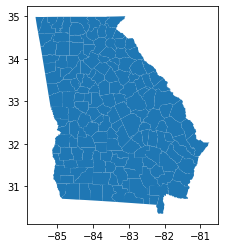

In [30]:
# using links provided in instructions as reference for this extra credit assignmento
# Got Georgia shapefile from the following link: https://arc-garc.opendata.arcgis.com/datasets/dc20713282734a73abe990995de40497/explore
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

georgia_map = gpd.read_file('Counties_Georgia.shp')
georgia_map = georgia_map.set_crs(epsg=4326)
georgia_map.plot()

In [31]:
crs = {'init':'EPSG:4326'}
long_lat_points = [Point(xy) for xy in zip(georgia_coords['EMPLOYER_LONGITUDE'], georgia_coords['EMPLOYER_LATITUDE'])]
geo_df_georgia = gpd.GeoDataFrame(georgia_coords, crs = crs, geometry = long_lat_points)
geo_df_georgia.head()

/Users/vaanigupta/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,EMPLOYER_ADDRESS_1,EMPLOYER_LATITUDE,EMPLOYER_LONGITUDE,geometry
0,534 McLain Cemetery Road,32.269747,-82.249009,POINT (-82.24901 32.26975)
1,9465 Miami Valley Rd,32.553646,-83.800710,POINT (-83.80071 32.55365)
2,30 Sand Creek Rd,31.471666,-83.573286,POINT (-83.57329 31.47167)
3,30 Sand Creek Rd,31.471666,-83.573286,POINT (-83.57329 31.47167)
4,1935 Ross Bowen Road,32.113000,-82.227285,POINT (-82.22729 32.11300)


<Axes: >

<Axes: >

Text(0.5, 1.0, 'Employer Addresses in Georgia')

Text(178.53994334201957, 0.5, 'Latitude')

Text(0.5, 42.0, 'Longitude')

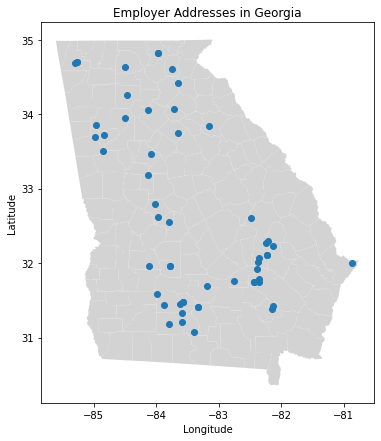

In [32]:
fig, axes = plt.subplots(figsize = (10,7))
georgia_map.plot(ax=axes, color='lightgrey')
geo_df_georgia.plot(ax=axes)
axes.set_title('Employer Addresses in Georgia')
axes.set_ylabel('Latitude')
axes.set_xlabel('Longitude')